<a href="https://colab.research.google.com/github/AnIsAsPe/LSM-Opciones-americanas/blob/main/LSM_Opciones_am%C3%A9ricanas_Azucar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funciones

#### simula_precios()

In [2]:
def simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias):
    np.random.seed(1)
    MatrizPrecios = np.zeros((T + 1, trayectorias), dtype = np.float64)
    MatrizPrecios[0,:] = precio_inicial  #en el primer renglón(dia0) coloca el precio inicial

    #vector con variable aleatoria distribución normal para cada una de las trayectorias
    
    #construir Proceso Brawniano Geométrico
    for i in range(1, T + 1):
        Z = np.random.standard_normal(trayectorias) 
        weiner_process = sigma * Z / np.sqrt(T)  
        MatrizPrecios[i, :] = (MatrizPrecios[i - 1, :] * np.exp((tasa_interes - sigma ** 2 / 2.) * 1 / T + weiner_process ))  # ec. (1.5) Gustafsson (2015)
  
    return pd.DataFrame(MatrizPrecios,  columns=['tr_'+ str(col) for col in range(1, trayectorias+1)])


#### LSM()

In [3]:
def LSM(precio_inicial, tasa_interes, sigma, T, trayectorias, precio_strike, tipo ='put'):
    df_precios = simula_precios(precio_inicial, tasa_interes, sigma, T, trayectorias)
    MatrizPrecios = df_precios.values
    descuento = np.exp(-tasa_interes/T)
    
    assert tipo == 'call' or tipo == 'put', "el tipo de opción solo puede ser 'call' o 'put'"
    
    if tipo == 'call':
       Ganancia = np.maximum(MatrizPrecios - precio_strike,
                             np.zeros((T + 1, trayectorias),dtype=np.float64))
    elif tipo == 'put':
       Ganancia = np.maximum(precio_strike - MatrizPrecios, 
                              np.zeros((T + 1, trayectorias),dtype=np.float64))

    MatrizValor = np.zeros_like(Ganancia)
    MatrizValor[-1, :] = Ganancia[-1, :]

    #Regresión polynomial por mínimos cuadrados
    for t in range(T - 1, 0 , -1):
        coeficientes= np.polyfit(MatrizPrecios[t, :],MatrizValor[t + 1, :] * descuento, 2)
        valor_continuar = np.polyval(coeficientes, MatrizPrecios[t, :])
        MatrizValor[t, :] = np.where(Ganancia[t, :] > valor_continuar,
                                     Ganancia[t, :], MatrizValor[t + 1, :] * descuento)

    valor_opcion_t0 = MatrizValor[1,:]*descuento
    return  np.mean(valor_opcion_t0)

# Leer y explorar serie de precios

In [4]:
#importar precios café 2020 obtenidos de Yahoo Finance

precio = pd.read_csv('/content/SB=F.csv',
                     usecols=['Date', 'Close'], parse_dates=['Date'], index_col = 'Date').dropna()
precio = precio['Close']
precio

Date
2020-01-02    13.13
2020-01-03    13.31
2020-01-06    13.73
2020-01-07    13.59
2020-01-08    13.47
              ...  
2020-12-22    14.54
2020-12-23    14.83
2020-12-28    14.98
2020-12-29    15.04
2020-12-30    15.28
Name: Close, Length: 250, dtype: float64

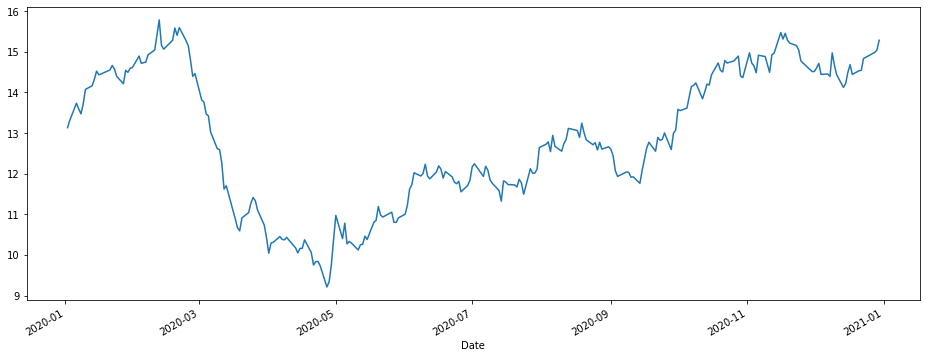

In [5]:
#visualizar serie
precio.plot(figsize=(16,6))
plt.show()

#Simulación Monte Carlo trayectorias de precio a un año
tasa de interés 6%

In [6]:
precio_ini = precio[-1]
sigma = np.std(precio)

precio_ini, sigma

(15.28, 1.6802378669700317)

In [23]:
#considerando la misma cantidad de días que en 2020 hacemos la simulación Montecarlo de un proceso Browniano
tasa = 0.06
dias = 250
n = 150000


Precios_df = simula_precios(precio_ini, tasa, sigma , dias, n )
Precios_df

,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,tr_10,tr_11,tr_12,tr_13,tr_14,tr_15,tr_16,tr_17,tr_18,tr_19,tr_20,tr_21,tr_22,tr_23,tr_24,tr_25,tr_26,tr_27,tr_28,tr_29,tr_30,tr_31,tr_32,tr_33,tr_34,tr_35,tr_36,tr_37,tr_38,tr_39,tr_40,...,tr_149961,tr_149962,tr_149963,tr_149964,tr_149965,tr_149966,tr_149967,tr_149968,tr_149969,tr_149970,tr_149971,tr_149972,tr_149973,tr_149974,tr_149975,tr_149976,tr_149977,tr_149978,tr_149979,tr_149980,tr_149981,tr_149982,tr_149983,tr_149984,tr_149985,tr_149986,tr_149987,tr_149988,tr_149989,tr_149990,tr_149991,tr_149992,tr_149993,tr_149994,tr_149995,tr_149996,tr_149997,tr_149998,tr_149999,tr_150000
0,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,...,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000,15.280000
1,18.060977,14.241048,14.368106,13.559896,16.661541,11.900251,18.293674,14.016662,15.721700,14.800166,17.752264,12.209474,14.685724,14.589847,17.143538,13.521157,14.921675,13.843980,15.265942,16.168627,13.520111,17.163506,16.725730,16.031207,16.724424,14.132545,15.000434,13.759045,14.771070,16.078741,14.120636,14.570171,14.127372,13.892101,14.151303,15.177173,13.496151,15.580952,18.129157,16.444542,...,14.400850,15.435263,16.148789,15.834944,15.829371,15.385677,16.056500,14.654463,14.663233,15.735352,14.208257,18.172435,16.308864,17.965813,14.865562,14.775807,15.811087,13.219800,15.429402,16.648724,15.427937,18.104377,15.595420,11.849839,14.470378,16.524677,11.950497,16.075215,16.586925,16.990441,12.721135,19.096850,14.825613,12.960851,16.300836,13.837594,15.649129,13.668974,13.727212,14.388036
2,16.406432,15.525565,16.113271,12.339173,15.717514,10.357286,17.824686,10.793508,15.070186,15.073589,15.177751,15.714292,14.516954,15.101181,17.965828,12.662336,13.432411,13.990352,13.852791,13.055334,11.367572,14.167911,16.570422,16.769069,14.257388,14.612480,15.065289,13.418244,12.777158,16.853214,14.433910,16.481583,13.223469,15.431832,13.495149,16.260150,12.906808,15.913034,15.494244,17.434526,...,14.482022,16.500478,12.293849,15.408182,15.399501,14.557709,14.639962,13.682927,14.839635,13.887729,12.295571,18.316342,17.453620,17.868868,16.261938,15.148341,16.617098,11.255410,11.771784,18.079706,17.437013,15.572615,17.813767,14.089284,14.646150,17.914076,12.866954,13.958286,14.364224,17.873546,13.791070,18.136799,14.882074,13.078345,19.618958,11.534960,14.794699,13.975136,14.287211,14.345353
3,16.838242,13.855051,15.540289,13.377374,18.234894,10.830479,19.338661,9.235002,18.788153,15.047159,11.177180,16.279105,17.222441,15.918875,16.891497,14.114789,13.464488,15.472302,12.967751,10.893959,11.406750,14.831921,17.815737,18.126607,14.814980,14.937887,14.370293,13.229549,11.951379,18.089154,12.428134,13.015859,13.223073,14.810115,14.453752,12.992366,11.124669,15.762530,13.341339,14.816000,...,15.137368,16.924211,12.192822,15.797058,18.069867,12.071751,15.064717,13.502969,14.793468,15.611398,14.712732,16.949329,17.550618,13.702277,15.469909,14.678610,14.704009,9.792009,12.517647,16.816688,18.772534,15.305456,16.138820,12.247627,14.713399,17.536470,13.213710,12.067225,11.604869,17.357544,15.433095,17.074688,12.423568,14.774022,18.007154,10.943446,14.325862,13.306954,17.518563,15.291400
4,16.924636,12.948856,13.512858,12.948717,14.945779,10.835134,20.672543,9.704801,20.642344,13.324474,13.633780,18.133367,18.254214,12.536742,1

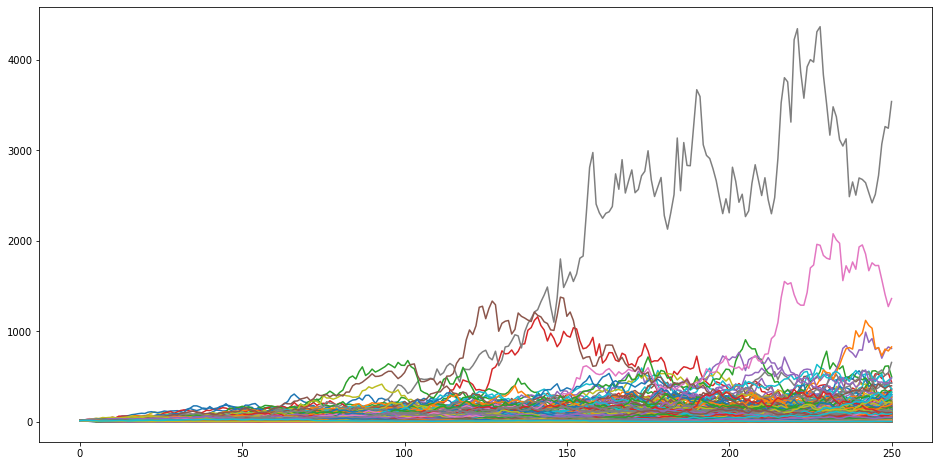

In [10]:
muestra = np.random.choice(Precios_df.columns, 5000)
Precios_df[muestra].plot(figsize=(16, 8), legend=False)


# Construcción de la Matriz de Ganancias

In [13]:
# Calcular Matriz de ganancias para opciones "put" 
# 0 si es igual o menor a 0 o strike-precio cuando es mayor que 0
Strike = 14
Ganancia = np.maximum(Strike - Precios_df.values, np.zeros((dias + 1, n),dtype=np.float64))
pd.DataFrame(Ganancia, columns = Precios_df.columns).head()

,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,tr_10,tr_11,tr_12,tr_13,tr_14,tr_15,tr_16,tr_17,tr_18,tr_19,tr_20,tr_21,tr_22,tr_23,tr_24,tr_25,tr_26,tr_27,tr_28,tr_29,tr_30,tr_31,tr_32,tr_33,tr_34,tr_35,tr_36,tr_37,tr_38,tr_39,tr_40,...,tr_149961,tr_149962,tr_149963,tr_149964,tr_149965,tr_149966,tr_149967,tr_149968,tr_149969,tr_149970,tr_149971,tr_149972,tr_149973,tr_149974,tr_149975,tr_149976,tr_149977,tr_149978,tr_149979,tr_149980,tr_149981,tr_149982,tr_149983,tr_149984,tr_149985,tr_149986,tr_149987,tr_149988,tr_149989,tr_149990,tr_149991,tr_149992,tr_149993,tr_149994,tr_149995,tr_149996,tr_149997,tr_149998,tr_149999,tr_150000
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.440104,0.0,2.099749,0.0,0.000000,0.0,0.000000,0.00000,1.790526,0.0,0.000000,0.0,0.478843,0.000000,0.156020,0.000000,0.000000,0.479889,0.000000,0.0,0.0,0.0,0.0,0.0,0.240955,0.000000,0.0,0.000000,0.000000,0.000000,0.107899,0.000000,0.000000,0.503849,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.780200,0.000000,0.0,0.0,0.0,0.0,2.150161,0.000000,0.0,2.049503,0.000000,0.000000,0.0,1.278865,0.0,0.000000,1.039149,0.0,0.162406,0.000000,0.331026,0.272788,0.0
2,0.0,0.000000,0.000000,1.660827,0.0,3.642714,0.0,3.206492,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,1.337664,0.567589,0.009648,0.147209,0.944666,2.632428,0.000000,0.0,0.0,0.0,0.0,0.0,0.581756,1.222842,0.0,0.000000,0.000000,0.776531,0.000000,0.504851,0.000000,1.093192,0.0,0.000000,0.0,...,0.0,0.000000,1.706151,0.000000,0.0,0.000000,0.0,0.317073,0.0,0.112271,1.704429,0.0,0.0,0.000000,0.000000,0.000000,0.0,2.744590,2.228216,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.133046,0.041714,0.000000,0.0,0.208930,0.0,0.000000,0.921655,0.0,2.465040,0.000000,0.024864,0.000000,0.0
3,0.0,0.144949,0.000000,0.622626,0.0,3.169521,0.0,4.764998,0.0,0.000000,2.82282,0.000000,0.0,0.000000,0.0,0.000000,0.535512,0.000000,1.032249,3.106041,2.593250,0.000000,0.0,0.0,0.0,0.0,0.0,0.770451,2.048621,0.0,1.571866,0.984141,0.776927,0.000000,0.000000,1.007634,2.875331,0.0,0.658661,0.0,...,0.0,0.000000,1.807178,0.000000,0.0,1.928249,0.0,0.497031,0.0,0.000000,0.000000,0.0,0.0,0.297723,0.000000,0.000000,0.0,4.207991,1.482353,0.0,0.0,0.0,0.0,1.752373,0.000000,0.0,0.786290,1.932775,2.395131,0.0,0.000000,0.0,1.576432,0.000000,0.0,3.056554,0.000000,0.693046,0.000000,0.0
4,0.0,1.051144,0.487142,1.051283,0.0,3.164866,0.0,4.295199,0.0,0.675526,0.36622,0.000000,0.0,1.463258,0.0,1.749348,3.588947,0.000000,0.854492,0.434850,3.878970,1.459692,0.0,0.0,0.0,0.0,0.0,2.898429,3.401111,0.0,0.060593,2.575145,2.484033,0.352111,1.423811,0.000000,3.118426,0.0,2.145843,0.0,...,0.0,0.886636,0.662039,0.566954,0.0,2.070681,0.0,0.615491,0.0,0.000000,0.000000,0.0,0.0,2.188713,1.763662,1.349999,0.0,3.875970,2.953470,0.0,0.0,0.0,0.0,0.574996,0.490627,0.0,1.320609,0.085809,3.884289,0.0,0.000000,0.0,2.127886,0.000000,0.0,2.247866,0.685812,0.000000,0.000000,0.0


# Construcción de la Matriz de Valor 

In [21]:
MatrizValor = np.zeros_like(Ganancia)
MatrizValor[-1, :] = Ganancia[-1, :]  #empezamos en el ultimo día
descuento = np.exp(-tasa/dias)

#Regresión polynomial por mínimos cuadrados para calcular el valor de continuar
for t in range(dias-1, 0 , -1):
    x = Precios_df.iloc[t,:]
    y = MatrizValor[t + 1, :] * descuento
    #encuentra los coeficientes 
    coeficientes = np.polyfit(x, y , 2)
    valor_continuar = np.polyval(coeficientes, x)
    #Cuando la ganancia en el tiempo t sea mayor que el valor de continuar,
    MatrizValor[t, :] = np.where(Ganancia[t, :] > valor_continuar,
                                  Ganancia[t, :],
                                  MatrizValor[t + 1, :] * descuento)

pd.DataFrame(MatrizValor, columns = Precios_df.columns).head(3)

,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,tr_10,tr_11,tr_12,tr_13,tr_14,tr_15,tr_16,tr_17,tr_18,tr_19,tr_20,tr_21,tr_22,tr_23,tr_24,tr_25,tr_26,tr_27,tr_28,tr_29,tr_30,tr_31,tr_32,tr_33,tr_34,tr_35,tr_36,tr_37,tr_38,tr_39,tr_40,...,tr_149961,tr_149962,tr_149963,tr_149964,tr_149965,tr_149966,tr_149967,tr_149968,tr_149969,tr_149970,tr_149971,tr_149972,tr_149973,tr_149974,tr_149975,tr_149976,tr_149977,tr_149978,tr_149979,tr_149980,tr_149981,tr_149982,tr_149983,tr_149984,tr_149985,tr_149986,tr_149987,tr_149988,tr_149989,tr_149990,tr_149991,tr_149992,tr_149993,tr_149994,tr_149995,tr_149996,tr_149997,tr_149998,tr_149999,tr_150000
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,9.422175,0.0,8.930513,9.536020,9.463348,8.372601,8.717273,8.892967,9.684337,0.0,9.232480,5.459894,5.254721,9.017844,0.0,9.164893,0.0,0.0,0.0,9.382044,0.0,9.076795,7.966188,9.040138,0.0,9.406606,8.391639,9.576735,9.269278,9.005163,0.0,8.973777,9.072308,2.040397,9.569056,9.163869,0.0,9.396593,8.815004,...,0.0,0.0,8.698392,8.791499,9.199088,8.906572,8.715249,8.781779,0.0,8.795413,8.766515,9.361014,0.0,8.632277,0.0,9.418327,8.725486,9.181510,9.282953,9.161102,9.208624,8.389995,0.0,0.0,0.0,8.370231,9.088655,8.853556,8.740461,8.274409,8.622912,8.245044,0.0,8.620102,8.751520,9.148369,9.078723,9.059094,9.389396,8.510402
2,0.0,9.424436,0.0,8.932657,9.538309,9.465619,8.374611,8.719365,8.895101,9.686661,0.0,9.234696,5.461205,5.255983,9.020009,0.0,9.167093,0.0,0.0,0.0,9.384296,0.0,9.078974,7.968100,9.042308,0.0,9.408864,8.393654,9.579034,9.271503,9.007325,0.0,8.975931,9.074485,2.040887,9.571353,9.166068,0.0,9.398849,8.817120,...,0.0,0.0,8.700480,8.793609,9.201296,8.908709,8.717341,8.783886,0.0,8.797524,8.768620,9.363261,0.0,8.634349,0.0,9.420588,8.727580,9.183714,9.285181,9.163301,9.210834,8.392009,0.0,0.0,0.0,8.372241,9.090836,8.855681,8.742559,8.276395,8.624982,8.247023,0.0,8.622172,8.753621,9.150565,9.080903,9.061268,9.391649,8.512445


In [20]:
valor_opcion_t0 = np.mean(MatrizValor[1,:]*descuento)
valor_opcion_t0

6.895748135085395

# Todo junto

In [28]:
precio_ini, Strike, sigma

(15.28, 14, 1.6802378669700317)

In [24]:
LSM(precio_ini, tasa, sigma, dias, n, Strike, 'put')

6.895748135085395

In [25]:
LSM(precio_ini, tasa, sigma, dias, n, Strike, 'call')

7.946914889428674